In [1]:
import scipy as sc
import sympy as sp
import numpy as np
import matplotlib.pyplot as plt

In [2]:
# Define symbols
s = sp.symbols('s')
D, H, tau = sp.symbols('D H tau')
D1, H1, tau1 = sp.symbols('D1 H1 tau1')
D2, H2, tau2 = sp.symbols('D2 H2 tau2')

# |I| = 1, K = 2
G = (-D - H*s)/(tau*s + 1) - (
    (-D1 - H1*s)/(tau1*s + 1) +
    (-D2 - H2*s)/(tau2*s + 1)
)

print("Symbolic Transfer Function G(s):")
sp.pprint(sp.simplify(G))

Symbolic Transfer Function G(s):
  D + H⋅s   D₁ + H₁⋅s   D₂ + H₂⋅s
- ─────── + ───────── + ─────────
  s⋅τ + 1   s⋅τ₁ + 1    s⋅τ₂ + 1 


Using the fact that:
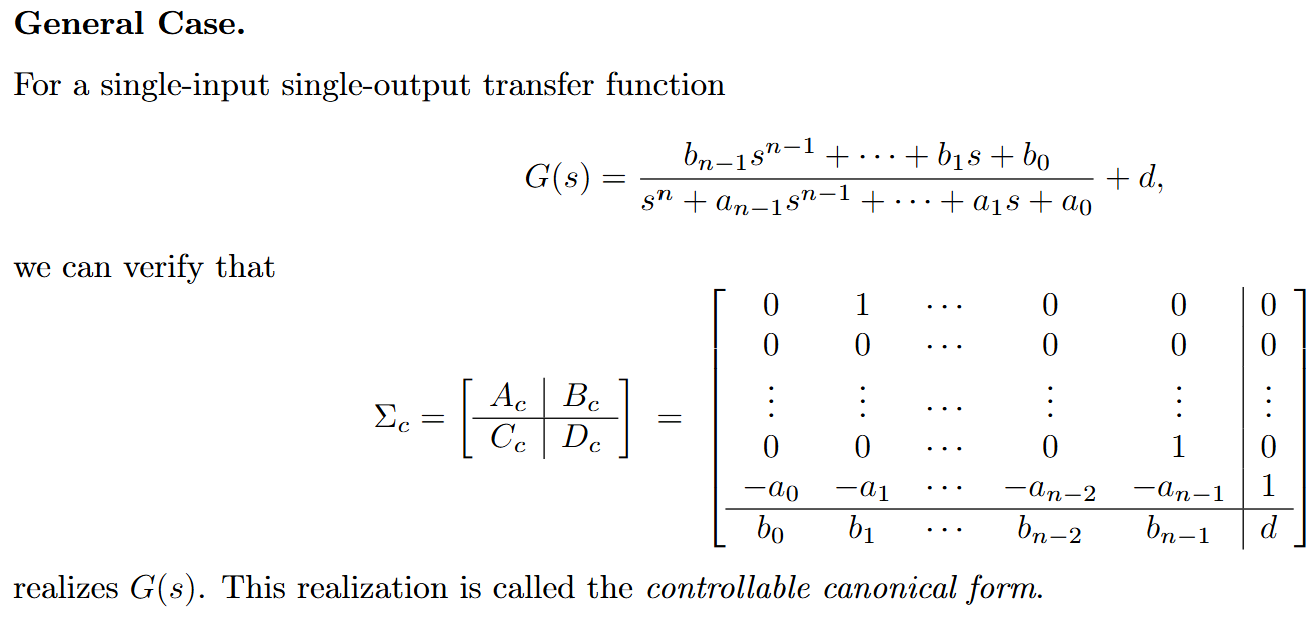

In [3]:
# --- Step 1: simplify into single rational function ---
G_simplified = sp.together(sp.simplify(G))  # forces common denominator
print("\nSimplified G(s):")
sp.pprint(G_simplified)

# --- Step 2: extract numerator and denominator ---
num, den = sp.fraction(G_simplified)

num_poly = sp.Poly(num, s)
den_poly = sp.Poly(den, s)

num_coeffs = num_poly.all_coeffs()
den_coeffs = den_poly.all_coeffs()

print("\nNumerator coefficients:", num_coeffs)
print("Denominator coefficients:", den_coeffs)

# important: devide by den_coeffs[0] always to normalize!!!

# Build controllable canonical form
n = len(den_coeffs) - 1  # system order

# Companion matrix A
A = sp.zeros(n)
for i in range(n-1):
    A[i, i+1] = 1
A[-1, :] = sp.Matrix([[-c/den_coeffs[0] for c in den_coeffs[1:]]])  # FIXED

# Input vector B
B = sp.zeros(n, 1)
B[-1, 0] = 1

# Output vector C
# Pad numerator if needed
m = len(num_coeffs)
if m < n+1:
    num_coeffs = [0]*(n+1-m) + num_coeffs
C = sp.Matrix([[c/den_coeffs[0] for c in num_coeffs[1:]]])

# Feedthrough term Dmat
Dmat = sp.Matrix([[num_coeffs[0]/den_coeffs[0]]])


Simplified G(s):
-(D + H⋅s)⋅(s⋅τ₁ + 1)⋅(s⋅τ₂ + 1) + (D₁ + H₁⋅s)⋅(s⋅τ + 1)⋅(s⋅τ₂ + 1) + (D₂ + H₂ ↪
────────────────────────────────────────────────────────────────────────────── ↪
                                   (s⋅τ + 1)⋅(s⋅τ₁ + 1)⋅(s⋅τ₂ + 1)             ↪

↪ ⋅s)⋅(s⋅τ + 1)⋅(s⋅τ₁ + 1)
↪ ────────────────────────
↪                         

Numerator coefficients: [-H*tau1*tau2 + H1*tau*tau2 + H2*tau*tau1, -D*tau1*tau2 + D1*tau*tau2 + D2*tau*tau1 - H*tau1 - H*tau2 + H1*tau + H1*tau2 + H2*tau + H2*tau1, -D*tau1 - D*tau2 + D1*tau + D1*tau2 + D2*tau + D2*tau1 - H + H1 + H2, -D + D1 + D2]
Denominator coefficients: [tau*tau1*tau2, tau*tau1 + tau*tau2 + tau1*tau2, tau + tau1 + tau2, 1]


In [4]:
from IPython.display import display

print("Controllable Canonical Form:")

print("\nA =")
display(A)   # nice LaTeX rendering

print("\nB =")
display(B)

print("\nC =")
display(C)

print("\nD =")
display(Dmat)


Controllable Canonical Form:

A =


Matrix([
[                                                 0,                                    1,                  0],
[                                                 0,                                    0,                  1],
[(-tau*tau1 - tau*tau2 - tau1*tau2)/(tau*tau1*tau2), (-tau - tau1 - tau2)/(tau*tau1*tau2), -1/(tau*tau1*tau2)]])


B =


Matrix([
[0],
[0],
[1]])


C =


Matrix([[(-D*tau1*tau2 + D1*tau*tau2 + D2*tau*tau1 - H*tau1 - H*tau2 + H1*tau + H1*tau2 + H2*tau + H2*tau1)/(tau*tau1*tau2), (-D*tau1 - D*tau2 + D1*tau + D1*tau2 + D2*tau + D2*tau1 - H + H1 + H2)/(tau*tau1*tau2), (-D + D1 + D2)/(tau*tau1*tau2)]])


D =


Matrix([[(-H*tau1*tau2 + H1*tau*tau2 + H2*tau*tau1)/(tau*tau1*tau2)]])

In [5]:
import control as ct

In [30]:
G = ct.tf([1], [2, 1], input='u1', output='y1')
G2 = ct.tf([1], [5, 1], input='u2', output='y2')
summing = ct.summing_junction(['y1', 'y2'], 'y', name='summing')
Gtot = ct.interconnect([G, G2, summing], inputs=['u1', 'u2'], outputs=['y1', 'y2', 'y'])
T = int(1e2)
t = np.arange(T) * 0.1
u1, u2 = np.ones(T), -np.ones(T)

response = ct.input_output_response(Gtot, t, [u1, u2], [1, -1])
response.outputs.shape

(3, 100)

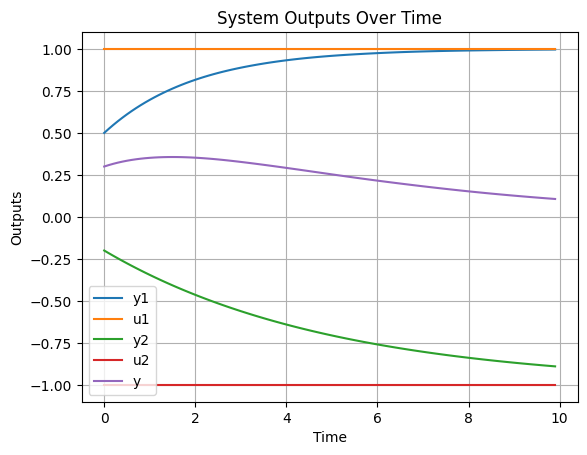

In [33]:
# plot ouput
plt.plot(response.time, response.outputs[0], label='y1')
plt.plot(response.time, response.inputs[0], label='u1')
plt.plot(response.time, response.outputs[1], label='y2')
plt.plot(response.time, response.inputs[1], label='u2')
plt.plot(response.time, response.outputs[2], label='y')
plt.xlabel('Time')
plt.ylabel('Outputs')
plt.legend()
plt.grid()
plt.title('System Outputs Over Time')
plt.show()